In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pandas as pd
import time
# Display plots inside Jupyter cell
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90

sys.path.append('/home/class_NI2021/ctxctl_contrib_0_14/')

import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params  

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# open DYNAP-SE1 board to get Dynapse1Model
device_name = 'dynapse_nsm' #pick any name, dynapse_groupA etc...
# change the port numbers to not have conflicts with other groups

#samna.device.close_device(device_name)

model, no_gui = ut.open_dynapse1(device_name, gui=False, sender_port=18425, receiver_port=10204, select_device=True)

# silent all neurons
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

[0]:  Bus 3 Device 13 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 102 Dynapse1DevKit serial_number 00000011
[2]:  Bus 1 Device 103 Dynapse1DevKit serial_number 00000020
[3]:  Bus 1 Device 100 Dynapse1DevKit serial_number 00000000
[4]:  Bus 1 Device 50 Dynapse1DevKit serial_number 00000007
[5]:  Bus 1 Device 98 Dynapse1DevKit serial_number 00000033
Select the device you want to open by index: 4
Sender port: tcp://0.0.0.0:18425
Receiver port: tcp://0.0.0.0:10204
Opened device name: dynapse_nsm
SamnaNode ID: 1
PythonNode ID: 2


In [2]:
def spike_generator(input_type, pulse_start, pulse_stop, rate, tit=''):
    #function to create spikes
    #input_type   = 'poisson' # 'regular', 'poisson' or 'cosine' (Default: poisson)
    #pulse_start         # second - Start time of input (Default: 0)
    #pulse_stop            # second - Stop time of input (Default: 5)
    inp_duration = pulse_stop - pulse_start # second - Simulation duration (Default: 5)
    #rate             # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine) 
    #tit --> title for the graph; if len(tit) is 0, no plot will be displayed

    if input_type == 'regular':
    
        spikes = np.zeros(inp_duration * 1000)
        dt = int(1000 / rate)
        spikes[pulse_start * 1000 : pulse_stop * 1000 : dt] = 1.0

    if input_type == 'poisson':

        prob = rate * 1e-3
        mask = np.random.rand(inp_duration * 1000)
        spikes = np.zeros(inp_duration * 1000)
        spikes[mask < prob] = 1.0

    if input_type == 'cosine':
        
        spikes = np.zeros(inp_duration * 1000)
        time = np.linspace(0, inp_duration, inp_duration * 1000)
        co = np.cos(2 * np.pi * rate * time)
        mask = 20 * np.random.rand(inp_duration * 1000)
        spikes[mask < co] = 1.0
        spikes[:pulse_start * 1000]=0
        spikes[pulse_stop * 1000:]=0

    if len(tit) > 0:
        plt.plot(spikes,'k|')
        plt.xlabel("Time (ms)")
        plt.ylabel("Neuron ID")
        plt.ylim(0.5, 1.5)
        plt.title (tit)
        plt.show()

    spikes = np.where(spikes == 1)[0] / 10e2
    return spikes.tolist()

In [110]:
def param_group_DC_AMPA_GABA(chip=0, core=0):
    paramGroup = dyn1.Dynapse1ParameterGroup()

    ### General parameters ###
    # THR, gain factor of neurons
    paramGroup.param_map["IF_THR_N"].coarse_value = 5
    paramGroup.param_map["IF_THR_N"].fine_value = 80

    # refactory period of neurons
    paramGroup.param_map["IF_RFR_N"].coarse_value = 4
    paramGroup.param_map["IF_RFR_N"].fine_value = 128

    # leakage of neurons
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 3
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    # turn off tau2
    paramGroup.param_map["IF_TAU2_N"].coarse_value = 7
    paramGroup.param_map["IF_TAU2_N"].fine_value = 255

    # turn off DC
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0
    
    ### Chip and core-spefific parameters ###
    
    # transitions
    if chip == 0 and core == 0:
        #AMPA = input to transitions
        # leakage of AMPA
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 20

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 5
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 5
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 100
        
        #####
        # GABA = from inh2 to transitions
        # leakage of GABA_B
        paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 2
        paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 80

        # gain of GABA_B
        paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 6
        paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 200

        # weight of GABA_B
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 200
        
    # states
    if chip == 0 and core == 1:

        # setting the DC current
        paramGroup.param_map["IF_DC_P"].coarse_value = 1
        paramGroup.param_map["IF_DC_P"].fine_value = 50
        
        #####
        #Transition to states
        # leakage of AMPA
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 3
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 40

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 7
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200
        
        ##### Recursion & Input to states
        
        # threshold of NMDA (setting to 0 -> NMDA acts as AMPA)
        paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
        paramGroup.param_map["IF_NMDA_N"].fine_value = 0
        
        # leakage of NMDA
        paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 1
        paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 200
        
        # gain of NMDA
        paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 6
        paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 250

        # weight of NMDA
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 7
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 250
        
        ##### GABAB = WTA to states
        
        # leakage of GABA_B
        paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 4
        paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 200

        # gain of GABA_B
        paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 5
        paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 250

        # weight of GABA_B
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 7
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 250
        
    # inh1 and inh2
    if chip == 0 and core == 2:
        # leakage of AMPA = states to inh1
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 3
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 40

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 6
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200
        
        ##### NMDA = sum to inh2
        
        # threshold of NMDA (setting to 0 -> NMDA acts as AMPA)
        paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
        paramGroup.param_map["IF_NMDA_N"].fine_value = 0
        
        # leakage of NMDA
        paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 2
        paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 40
        
        # gain of NMDA
        paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 5
        paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 200

        # weight of NMDA
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 200
        
        ##### GABA B = Inh1 to Inh2
        
        # leakage of GABA_B
        paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 2
        paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 80

        # gain of GABA_B
        paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 6
        paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 200

        # weight of GABA_B
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 200
        
#         #####
        
#         # leakage of GABA_A
#         paramGroup.param_map["NPDPII_TAU_F_P"].coarse_value = 3
#         paramGroup.param_map["NPDPII_TAU_F_P"].fine_value = 80

#         # gain of GABA_A
#         paramGroup.param_map["NPDPII_THR_F_P"].coarse_value = 4
#         paramGroup.param_map["NPDPII_THR_F_P"].fine_value = 100

#         # weight of GABA_A
#         paramGroup.param_map["PS_WEIGHT_INH_F_N"].coarse_value = 6
#         paramGroup.param_map["PS_WEIGHT_INH_F_N"].fine_value = 200
    
    # s_sum and wta
    if chip == 0 and core == 3:
        #AMPA = sum to WTA
        # leakage of AMPA 
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 2
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 50

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 7
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200
        
        #####
        #NMDA = states to sum
        # threshold of NMDA (setting to 0 -> NMDA acts as AMPA)
        paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
        paramGroup.param_map["IF_NMDA_N"].fine_value = 0
        
        # leakage of NMDA
        paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 2
        paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 50
        
        # gain of NMDA
        paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 5
        paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 150

        # weight of NMDA
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 200
        
    return paramGroup

<img src="network-base.png" width="45%"/>

In [111]:
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

net_gen = n.NetworkGenerator()
net_gen.clear_network()

chip = 0 

# inputs (excitatory)
spikegen_ids = [(chip, 0, 100), (chip, 0, 200)]
spikegens = []
for spikegen_id in spikegen_ids:
    spikegens.append(n.Neuron(spikegen_id[0], spikegen_id[1], spikegen_id[2], True))

# spikegens = [n.NeuronGroup(chip, 0, [100], True), n.NeuronGroup(chip, 0, [200], True)]

transitions = [n.Neuron(chip, 0, 1), n.Neuron(chip, 0, 2), n.Neuron(chip, 0, 3)] # t_1, t_2, t_3

s1_neurons = np.arange(101, 109, 1) # 101, 102, 103, 104, 105, 106, 107, 108
s2_neurons = np.arange(111, 119, 1) # 111, 112, 113, 114, 115, 116, 117, 118
s3_neurons = np.arange(121, 129, 1) # 121, 122, 123, 124, 125, 126, 127, 128
states = [n.NeuronGroup(chip, 1, s1_neurons), # s_1
          n.NeuronGroup(chip, 1, s2_neurons), # s_2
          n.NeuronGroup(chip, 1, s3_neurons)] # s_3

inh1 = [n.Neuron(chip, 2, 21), n.Neuron(chip, 2, 22), n.Neuron(chip, 2, 23)] # first group of inh neurons
inh2 = [n.Neuron(chip, 2, 31), n.Neuron(chip, 2, 32), n.Neuron(chip, 2, 33)] # second group of inh neurons
s_sum = n.Neuron(chip, 3, 41)
in_wta = n.Neuron(chip, 3, 51)

# CONNECTIONS

#Initializing states with poissongen
net_gen.add_connections_from_list(8 * [spikegens[1]], states[0].neurons, dyn1.Dynapse1SynType.AMPA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # input -> s_1

#Signal to transtions
net_gen.add_connection(spikegens[0], transitions[0], dyn1.Dynapse1SynType.AMPA) # input -> t_1
net_gen.add_connection(spikegens[0], transitions[1], dyn1.Dynapse1SynType.AMPA) # input -> t_2
net_gen.add_connection(spikegens[0], transitions[2], dyn1.Dynapse1SynType.AMPA) # input -> t_3

#Transtions to states
net_gen.add_connections_from_list(8 * [transitions[0]], states[1].neurons, dyn1.Dynapse1SynType.AMPA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # t_1 -> s_2
net_gen.add_connections_from_list(8 * [transitions[1]], states[2].neurons, dyn1.Dynapse1SynType.AMPA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # t_2 -> s_3
net_gen.add_connections_from_list(8 * [transitions[2]], states[0].neurons, dyn1.Dynapse1SynType.AMPA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # t_3 -> s_1

#Recursion in states
syn = n.Synapses(states[0], states[0], dyn1.Dynapse1SynType.NMDA, conn_type='all2all') # s_1 -> s_1
n.add_synapses(net_gen, syn)
syn = n.Synapses(states[1], states[1], dyn1.Dynapse1SynType.NMDA, conn_type='all2all') # s_2 -> s_2
n.add_synapses(net_gen, syn)
syn = n.Synapses(states[2], states[2], dyn1.Dynapse1SynType.NMDA, conn_type='all2all') # s_3 -> s_3
n.add_synapses(net_gen, syn)

#States to sum
net_gen.add_connections_from_list(states[0].neurons, 8 * [s_sum], dyn1.Dynapse1SynType.NMDA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # s_1 -> s_sum
net_gen.add_connections_from_list(states[1].neurons, 8 * [s_sum], dyn1.Dynapse1SynType.NMDA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # s_2 -> s_sum
net_gen.add_connections_from_list(states[2].neurons, 8 * [s_sum], dyn1.Dynapse1SynType.NMDA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # s_3 -> s_sum

#Sum to WTA & Inh2
net_gen.add_connection(s_sum, in_wta, dyn1.Dynapse1SynType.AMPA) # s_sum -> in_wta
net_gen.add_connection(s_sum, inh2[0], dyn1.Dynapse1SynType.NMDA) # s_sum -> inh21
net_gen.add_connection(s_sum, inh2[1], dyn1.Dynapse1SynType.NMDA) # s_sum -> inh22
net_gen.add_connection(s_sum, inh2[2], dyn1.Dynapse1SynType.NMDA) # s_sum -> inh23

#Inhibitory WTA to states
net_gen.add_connections_from_list(8 * [in_wta], states[0].neurons, dyn1.Dynapse1SynType.GABA_B, np.arange(0, 8, 1), np.arange(0, 8, 1)) # in_wta -> s_1
net_gen.add_connections_from_list(8 * [in_wta], states[1].neurons, dyn1.Dynapse1SynType.GABA_B, np.arange(0, 8, 1), np.arange(0, 8, 1)) # in_wta -> s_2
net_gen.add_connections_from_list(8 * [in_wta], states[2].neurons, dyn1.Dynapse1SynType.GABA_B, np.arange(0, 8, 1), np.arange(0, 8, 1)) # in_wta -> s_3

#States to INh1
net_gen.add_connections_from_list(states[0].neurons, 8 * [inh1[0]], dyn1.Dynapse1SynType.AMPA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # s_1 -> inh11
net_gen.add_connections_from_list(states[1].neurons, 8 * [inh1[1]], dyn1.Dynapse1SynType.AMPA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # s_2 -> inh12
net_gen.add_connections_from_list(states[2].neurons, 8 * [inh1[2]], dyn1.Dynapse1SynType.AMPA, np.arange(0, 8, 1), np.arange(0, 8, 1)) # s_3 -> inh13

#Inhibitory Inh1 to Inh2
net_gen.add_connection(inh1[0], inh2[0], dyn1.Dynapse1SynType.GABA_B) # inh11 -> inh21
net_gen.add_connection(inh1[1], inh2[1], dyn1.Dynapse1SynType.GABA_B) # inh11 -> inh22
net_gen.add_connection(inh1[2], inh2[2], dyn1.Dynapse1SynType.GABA_B) # inh11 -> inh23

#Inhibitory Inh1 to Inh2
net_gen.add_connection(inh2[0], transitions[0], dyn1.Dynapse1SynType.GABA_B) # inh21 -> t_1
net_gen.add_connection(inh2[1], transitions[1], dyn1.Dynapse1SynType.GABA_B) # inh22 -> t_2
net_gen.add_connection(inh2[2], transitions[2], dyn1.Dynapse1SynType.GABA_B) # inh23 -> t_3

new_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(new_config)

param_group0 = param_group_DC_AMPA_GABA(chip, 0)
model.update_parameter_group(param_group0, chip, 0)
param_group1 = param_group_DC_AMPA_GABA(chip, 1)
model.update_parameter_group(param_group1, chip, 1)
param_group2 = param_group_DC_AMPA_GABA(chip, 2)
model.update_parameter_group(param_group2, chip, 2)
param_group3 = param_group_DC_AMPA_GABA(chip, 3)
model.update_parameter_group(param_group3, chip, 3)

# config3 = model.get_configuration()
# for core_idx in range(4):
#     print('chip' + str(chip) +', core' + str(core_idx) + ' ' + str(config3.chips[chip].cores[core_idx].parameter_group.param_map['IF_NMDA_N'].coarse_value))

time.sleep(1)

In [112]:
# # Visualize connectivity
# def visualise_connectivity(S):
#     Ns = len(S.source)
#     Nt = len(S.target)
#     plt.figure(figsize=(10, 4))
#     plt.subplot(121)
#     plt.plot(zeros(Ns), arange(Ns), 'ok', ms=10)
#     plt.plot(ones(Nt), arange(Nt), 'ok', ms=10)
#     for i, j in zip(S.i, S.j):
#         plt.plot([0, 1], [i, j], '-k')
#     plt.xticks([0, 1], ['Source', 'Target'])
#     plt.ylabel('Neuron index')
#     plt.xlim(-0.1, 1.1)
#     plt.ylim(-1, max(Ns, Nt))
#     plt.subplot(122)
#     plt.plot(S.i, S.j, 'ok')
#     plt.xlim(-1, Ns)
#     plt.ylim(-1, Nt)
#     plt.xlabel('Source neuron index')
#     plt.ylabel('Target neuron index')
    
# visualise_connectivity(syn)

In [113]:
# #-----------------------------------spike generator-------------------------------------
# fpga_spike_gen = model.get_fpga_spike_gen()
# poisson_time = 5
# spike_times_input = spike_generator('poisson', 0, poisson_time, 100)
# #
# spike_times_state = spike_generator('poisson', 0, 10, 50)
# #
# spike_times = spike_times_input + spike_times_state

# device_indices = len(spike_times_input) * [spikegens[0].neuron_id] + len(spike_times_state) * [spikegens[1].neuron_id]

# # spike_times = spike_times_state
# # device_indices = len(spike_times_state) * [spikegens[1].neuron_id]

# # Spike times need to be sorted for FPGA
# spike_times, device_indices= zip(*sorted(zip(spike_times, device_indices)))

# # The chips where the post neurons are
# target_chips = [chip] * len(spike_times)

# isi_base = 900
# repeat_mode = False
# ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, device_indices, target_chips, isi_base, repeat_mode)

In [114]:
#-----------------------------------poisson generator-------------------------------------
spikegen_ids = [(chip, 0, 100), (chip, 0, 200)]
global_poisson_gen_ids = ut.get_global_id_list(spikegen_ids)

# get poissongen from the model
poisson_gen_transitions = model.get_poisson_gen()
poisson_gen_states = model.get_poisson_gen()
# set the target chip of the post neurons
post_chip = 0
poisson_gen_transitions.set_chip_id(post_chip)
poisson_gen_states.set_chip_id(post_chip)

poisson_gen_transitions.write_poisson_rate_hz(global_poisson_gen_ids[0], 10)
poisson_gen_states.write_poisson_rate_hz(global_poisson_gen_ids[1], 100)

In [115]:
t_neurons = [(chip, 0, 1), (chip, 0, 2), (chip, 0, 3)] # t_1, t_2, t_3
s1_neurons = [(chip, 1, 101), (chip, 1, 102), (chip, 1, 103), (chip, 1, 104), (chip, 1, 105), (chip, 1, 106), (chip, 1, 107), (chip, 1, 108)] # s_1
s2_neurons = [(chip, 1, 111), (chip, 1, 112), (chip, 1, 113), (chip, 1, 114), (chip, 1, 115), (chip, 1, 116), (chip, 1, 117), (chip, 1, 118)] # s_2
s3_neurons = [(chip, 1, 121), (chip, 1, 122), (chip, 1, 123), (chip, 1, 124), (chip, 1, 125), (chip, 1, 126), (chip, 1, 127), (chip, 1, 128)] # s_3
inh1_neurons = [(chip, 2, 21), (chip, 2, 22), (chip, 2, 23)] # first group of inh neurons
inh2_neurons = [(chip, 2, 31), (chip, 2, 32), (chip, 2, 33)] # second group of inh neurons
sum_neurons = [(chip, 3, 41)] # s_sum
wta_neurons = [(chip, 3, 51)] # in_wta
monitored_neurons = t_neurons + s1_neurons + s2_neurons + s3_neurons + inh1_neurons + inh2_neurons + sum_neurons + wta_neurons

graph, filter_node, sink_node = ut.create_neuron_select_graph(model, monitored_neurons)

graph.start()
sink_node.get_events()

# ### run with spikegen ###
# fpga_spike_gen.start() # Start spike generator
# duration = 30 # This is the duration of the recording
# time.sleep(duration)
# fpga_spike_gen.stop()  # Stop spike generator
# events = sink_node.get_events()
# graph.stop()
# ### spikegen end ###

### run with poisson gen ###
duration_list = [5, 15, 1, 5] # This is the duration of the recording
#States, sleep, transitons/signal, sleep

poisson_gen_states.start()
time.sleep(duration_list[0])
poisson_gen_states.stop()

time.sleep(duration_list[1])

poisson_gen_transitions.start()
time.sleep(duration_list[2])
poisson_gen_transitions.stop()

time.sleep(duration_list[3])
events = sink_node.get_events()
graph.stop()
### poisson end ###

evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
timestamp_offset = 0 
df_spikes = pd.DataFrame()
for evt in events:
    if timestamp_offset == 0:
        timestamp_offset = evt.timestamp
    spikeData = dict(chip = evt.chip_id, 
                     core = evt.core_id,
                     neuron_id = evt.neuron_id,
                     times = (evt.timestamp - timestamp_offset) * 1e-6)
    df_spikes = pd.concat([df_spikes, pd.DataFrame(spikeData, index=[0])])

In [116]:
neuron_groups = {'Transitions': t_neurons,
                 'States': [s1_neurons, s2_neurons, s3_neurons],
                 'Inhibitory 1': inh1_neurons,
                 'Inhibitory 2' : inh2_neurons,
                 'Sum and WTA': sum_neurons + wta_neurons}

def plot_all(df, title, neuron_groups=neuron_groups, duration_list=duration_list):
    neuron_group = neuron_groups[title]
    fig, axs = plt.subplots(3, 1, figsize=(16, 10))
    plt.subplots_adjust(wspace=None, hspace=1)
    fig.suptitle(title)
    num_subplots = len(neuron_group)
    for i in range(num_subplots):
        if title != 'States':
            chip, core, neuron_id = neuron_group[i]
            df1 = df[(df['chip'] == chip) & (df['core'] == core) & (df['neuron_id'] == neuron_id)]
            firing_rate = len(df1) / sum(duration_list)

            axs[i].plot(df1['times'].values, df1['neuron_id'].values, 'k|')
            axs[i].set_xlabel("time (s)")
            axs[i].set_ylabel("neuron id")
            axs[i].set_title('chip ' + str(chip) + ', core ' + str(core) + ', neuron_id ' + str(neuron_id) +
                             ' (firing rate=' + str(round(firing_rate, 1)) + ' Hz)')
        else:
            neuron_group1 = neuron_group[i]
            neuron_ids = [j[2] for j in neuron_group1]
            chip = neuron_group1[0][0]
            core = neuron_group1[0][1]
            df1 = df[df['neuron_id'].isin(neuron_ids)]
#             display(df1[df1['neuron_id'] == neuron_group1[0][2]])
            firing_rate = len(df1[df1['neuron_id'] == neuron_group1[0][2]]) / sum(duration_list)

            axs[i].plot(df1['times'].values, df1['neuron_id'].values, 'k|')
            axs[i].set_xlabel("time (s)")
            axs[i].set_ylabel("neuron id")
            axs[i].set_title('chip ' + str(chip) + ', core ' + str(core) + ', neuron_ids ' + str(', '.join(map(str, neuron_ids))) +
                             ' (firing rate=' + str(round(firing_rate, 1)) + ' Hz)')
            
#         else:
#             axs.plot(df1['times'].values, df1['neuron_id'].values, 'k|')
#             axs.set_xlabel("time (s)")
#             axs.set_ylabel("neuron id")
#             axs.set_title('chip ' + str(chip) + ', core ' + str(core) + ', neuron_id ' + str(neuron_id))

In [117]:
df_spikes[df_spikes["core"]==1]

,chip,core,neuron_id,times


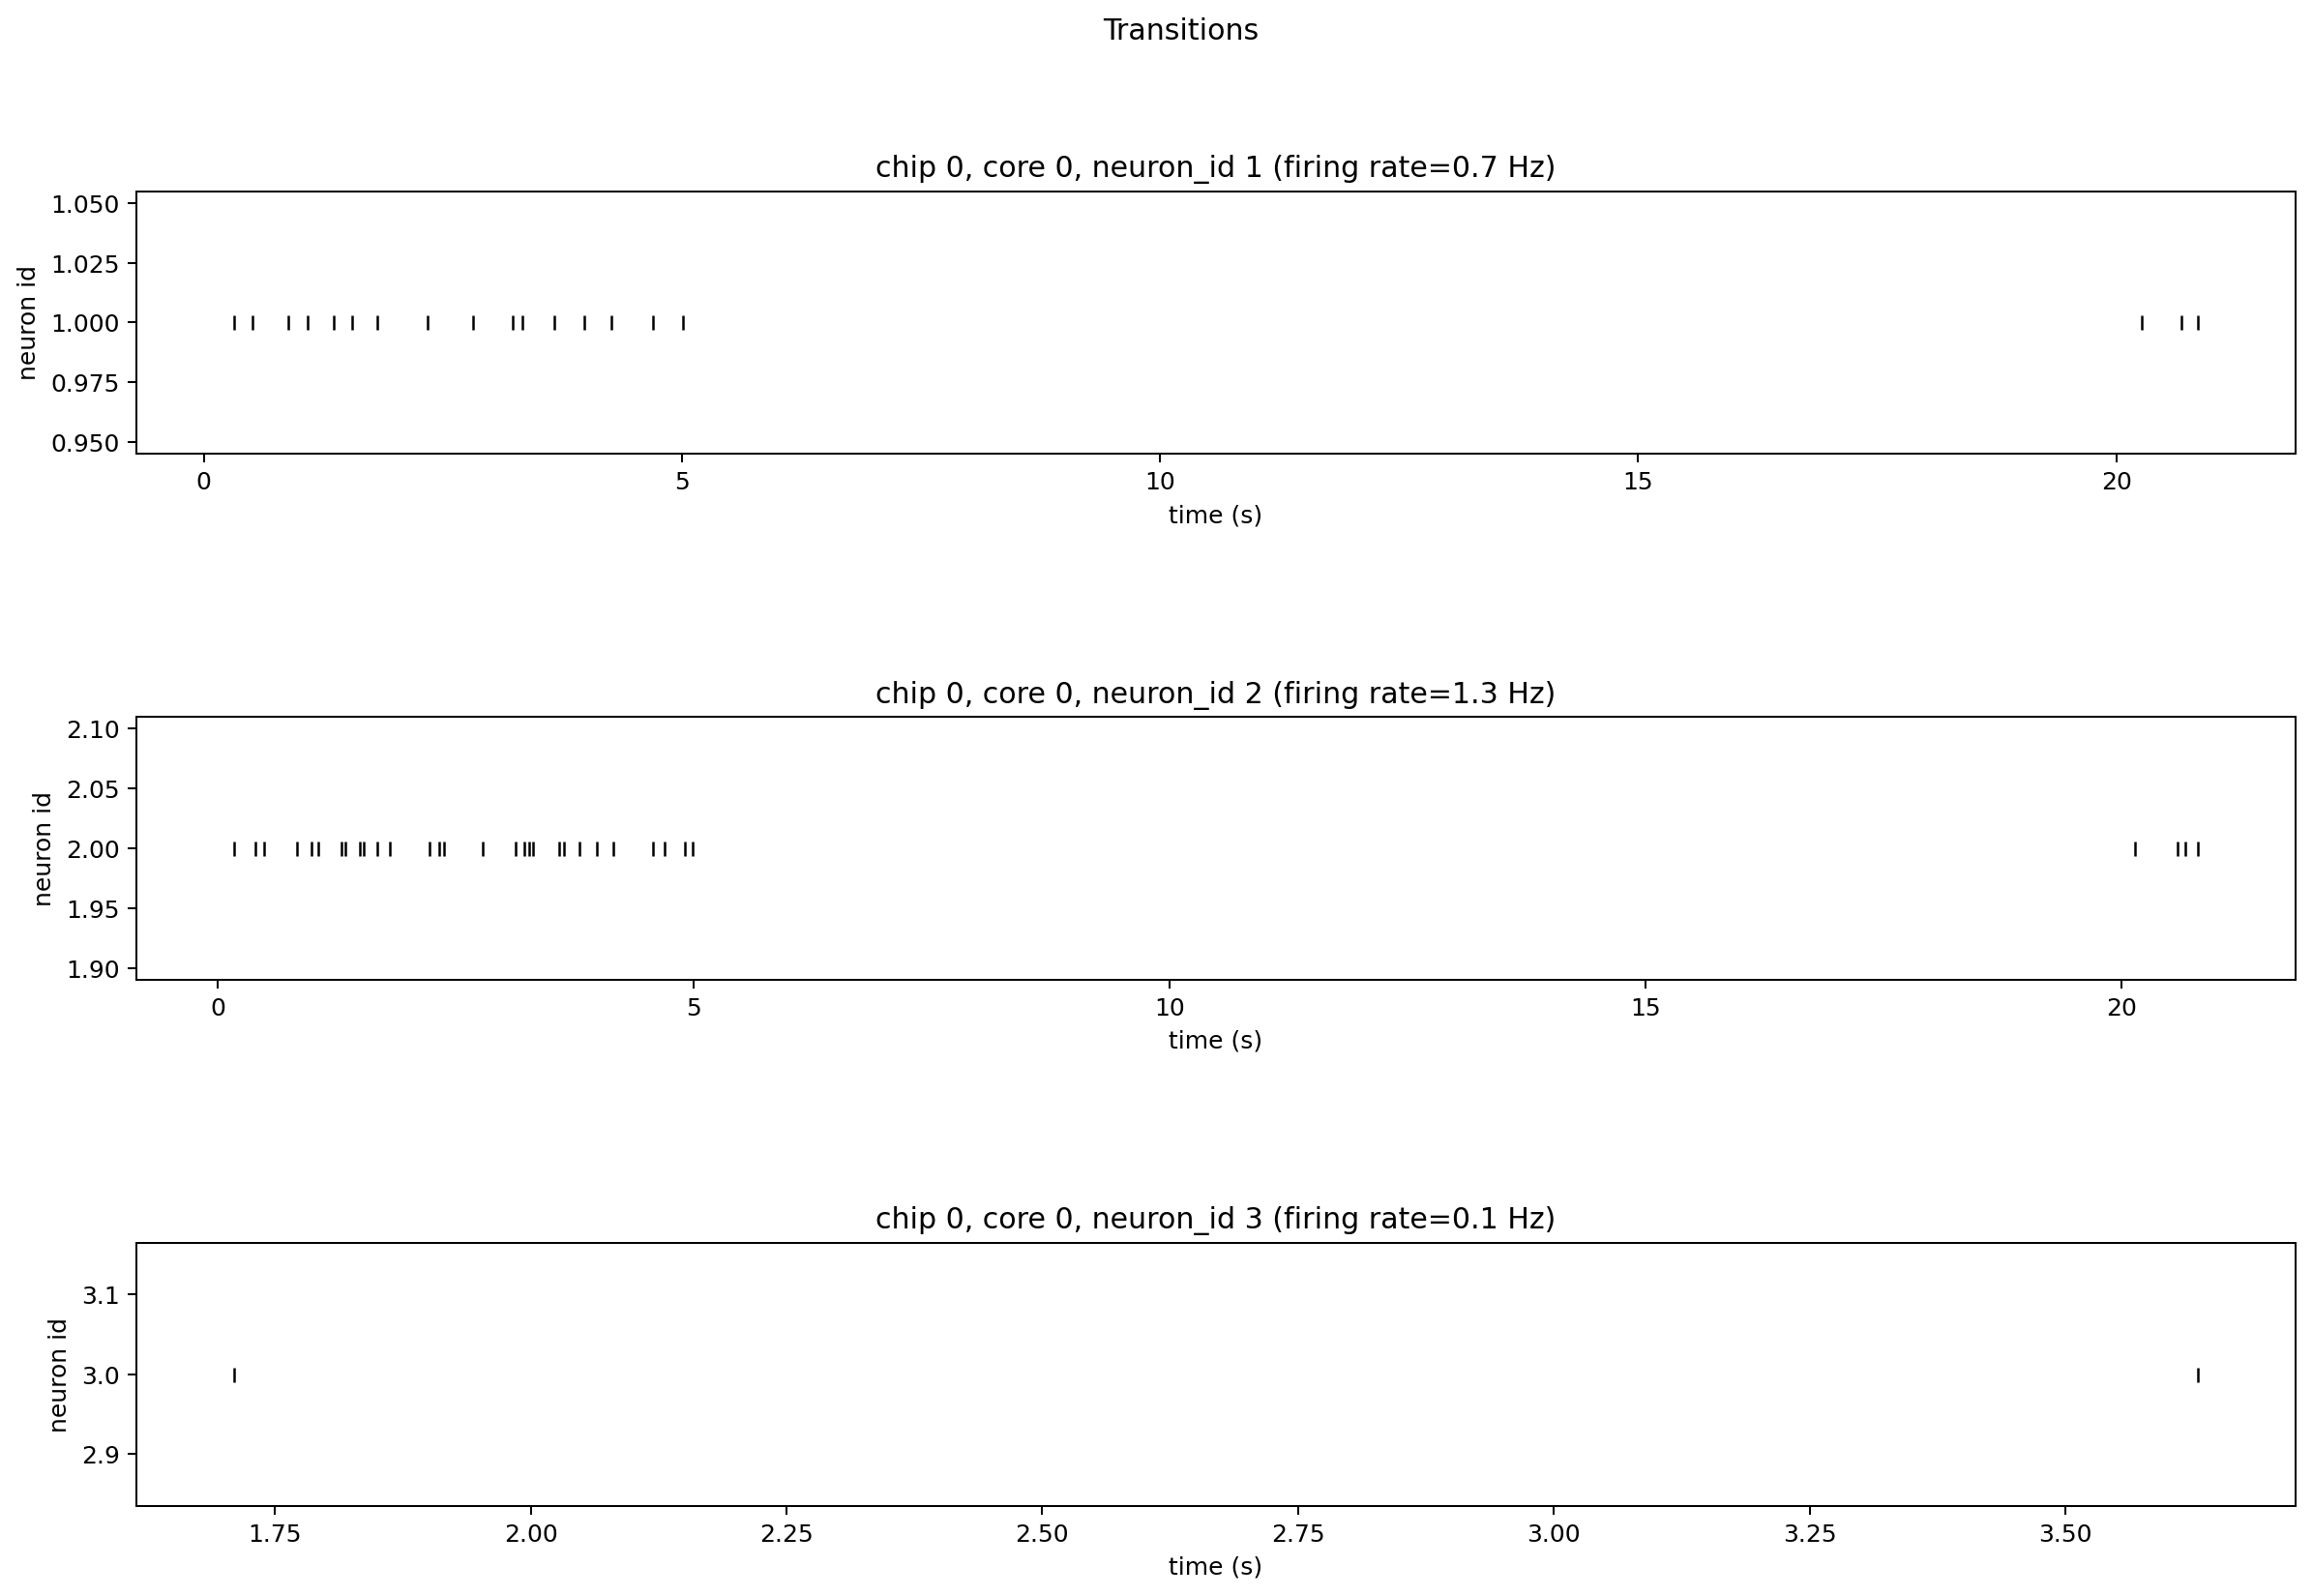

In [118]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'Transitions')     

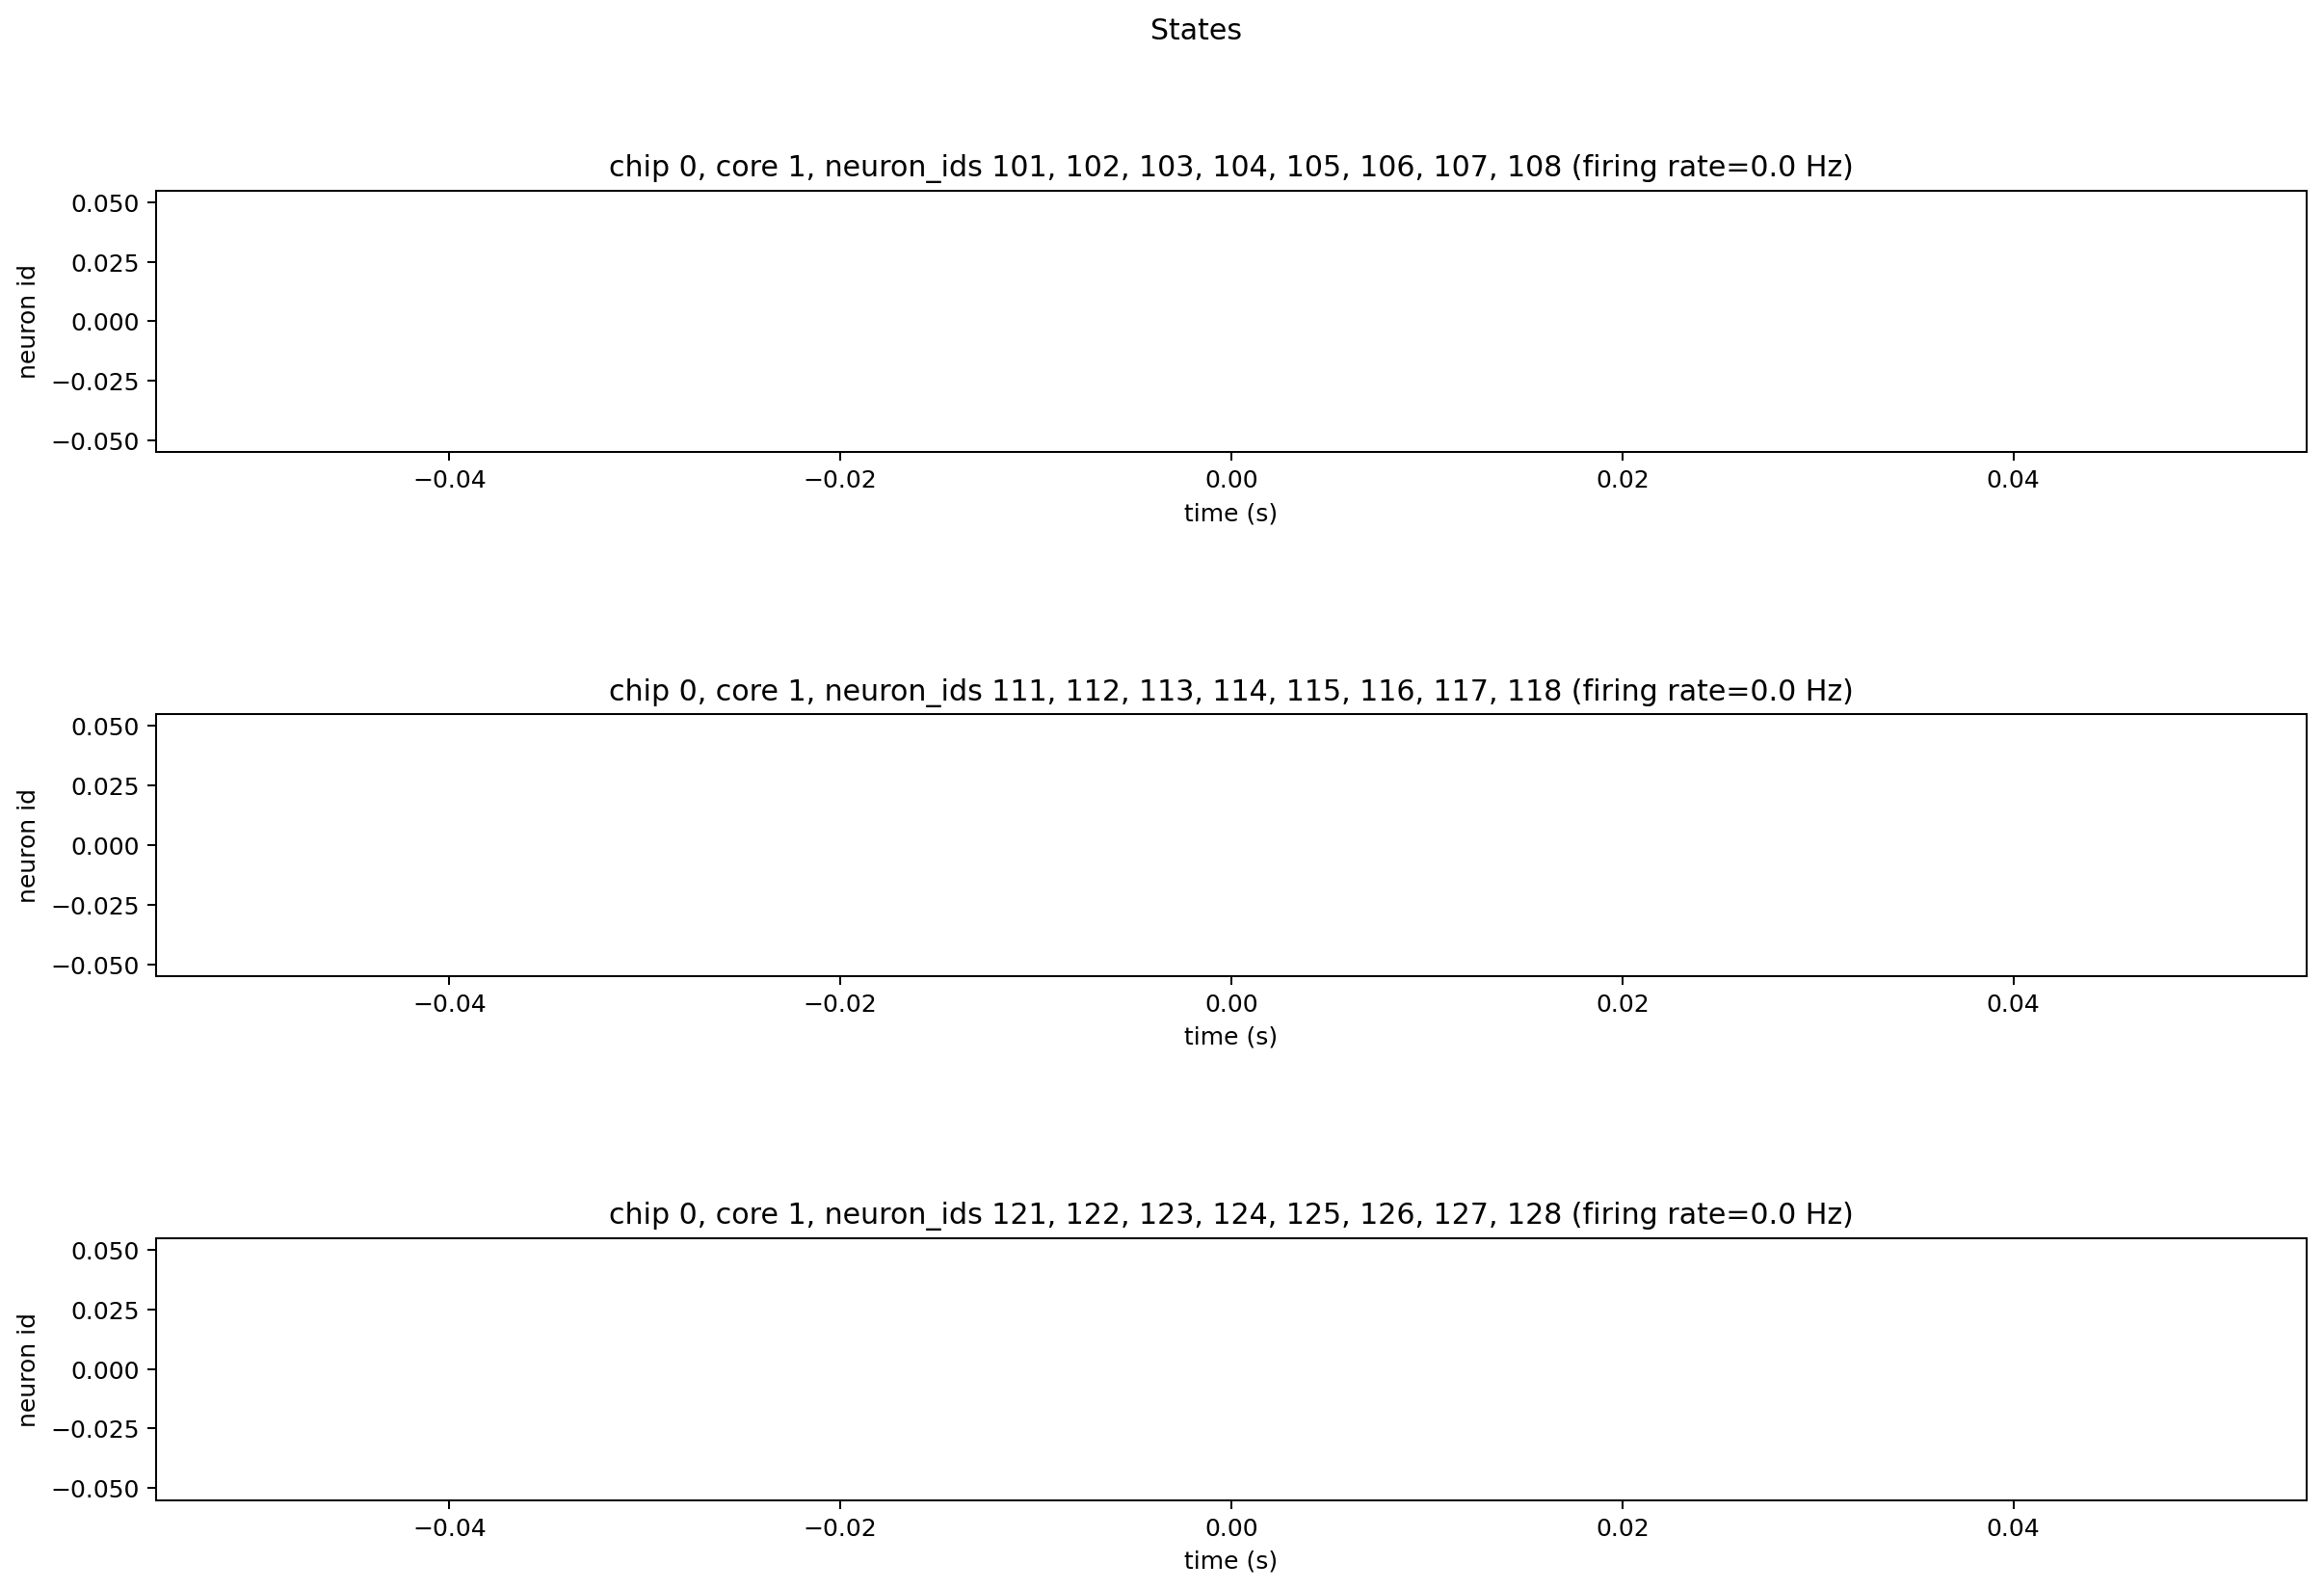

In [119]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'States') 

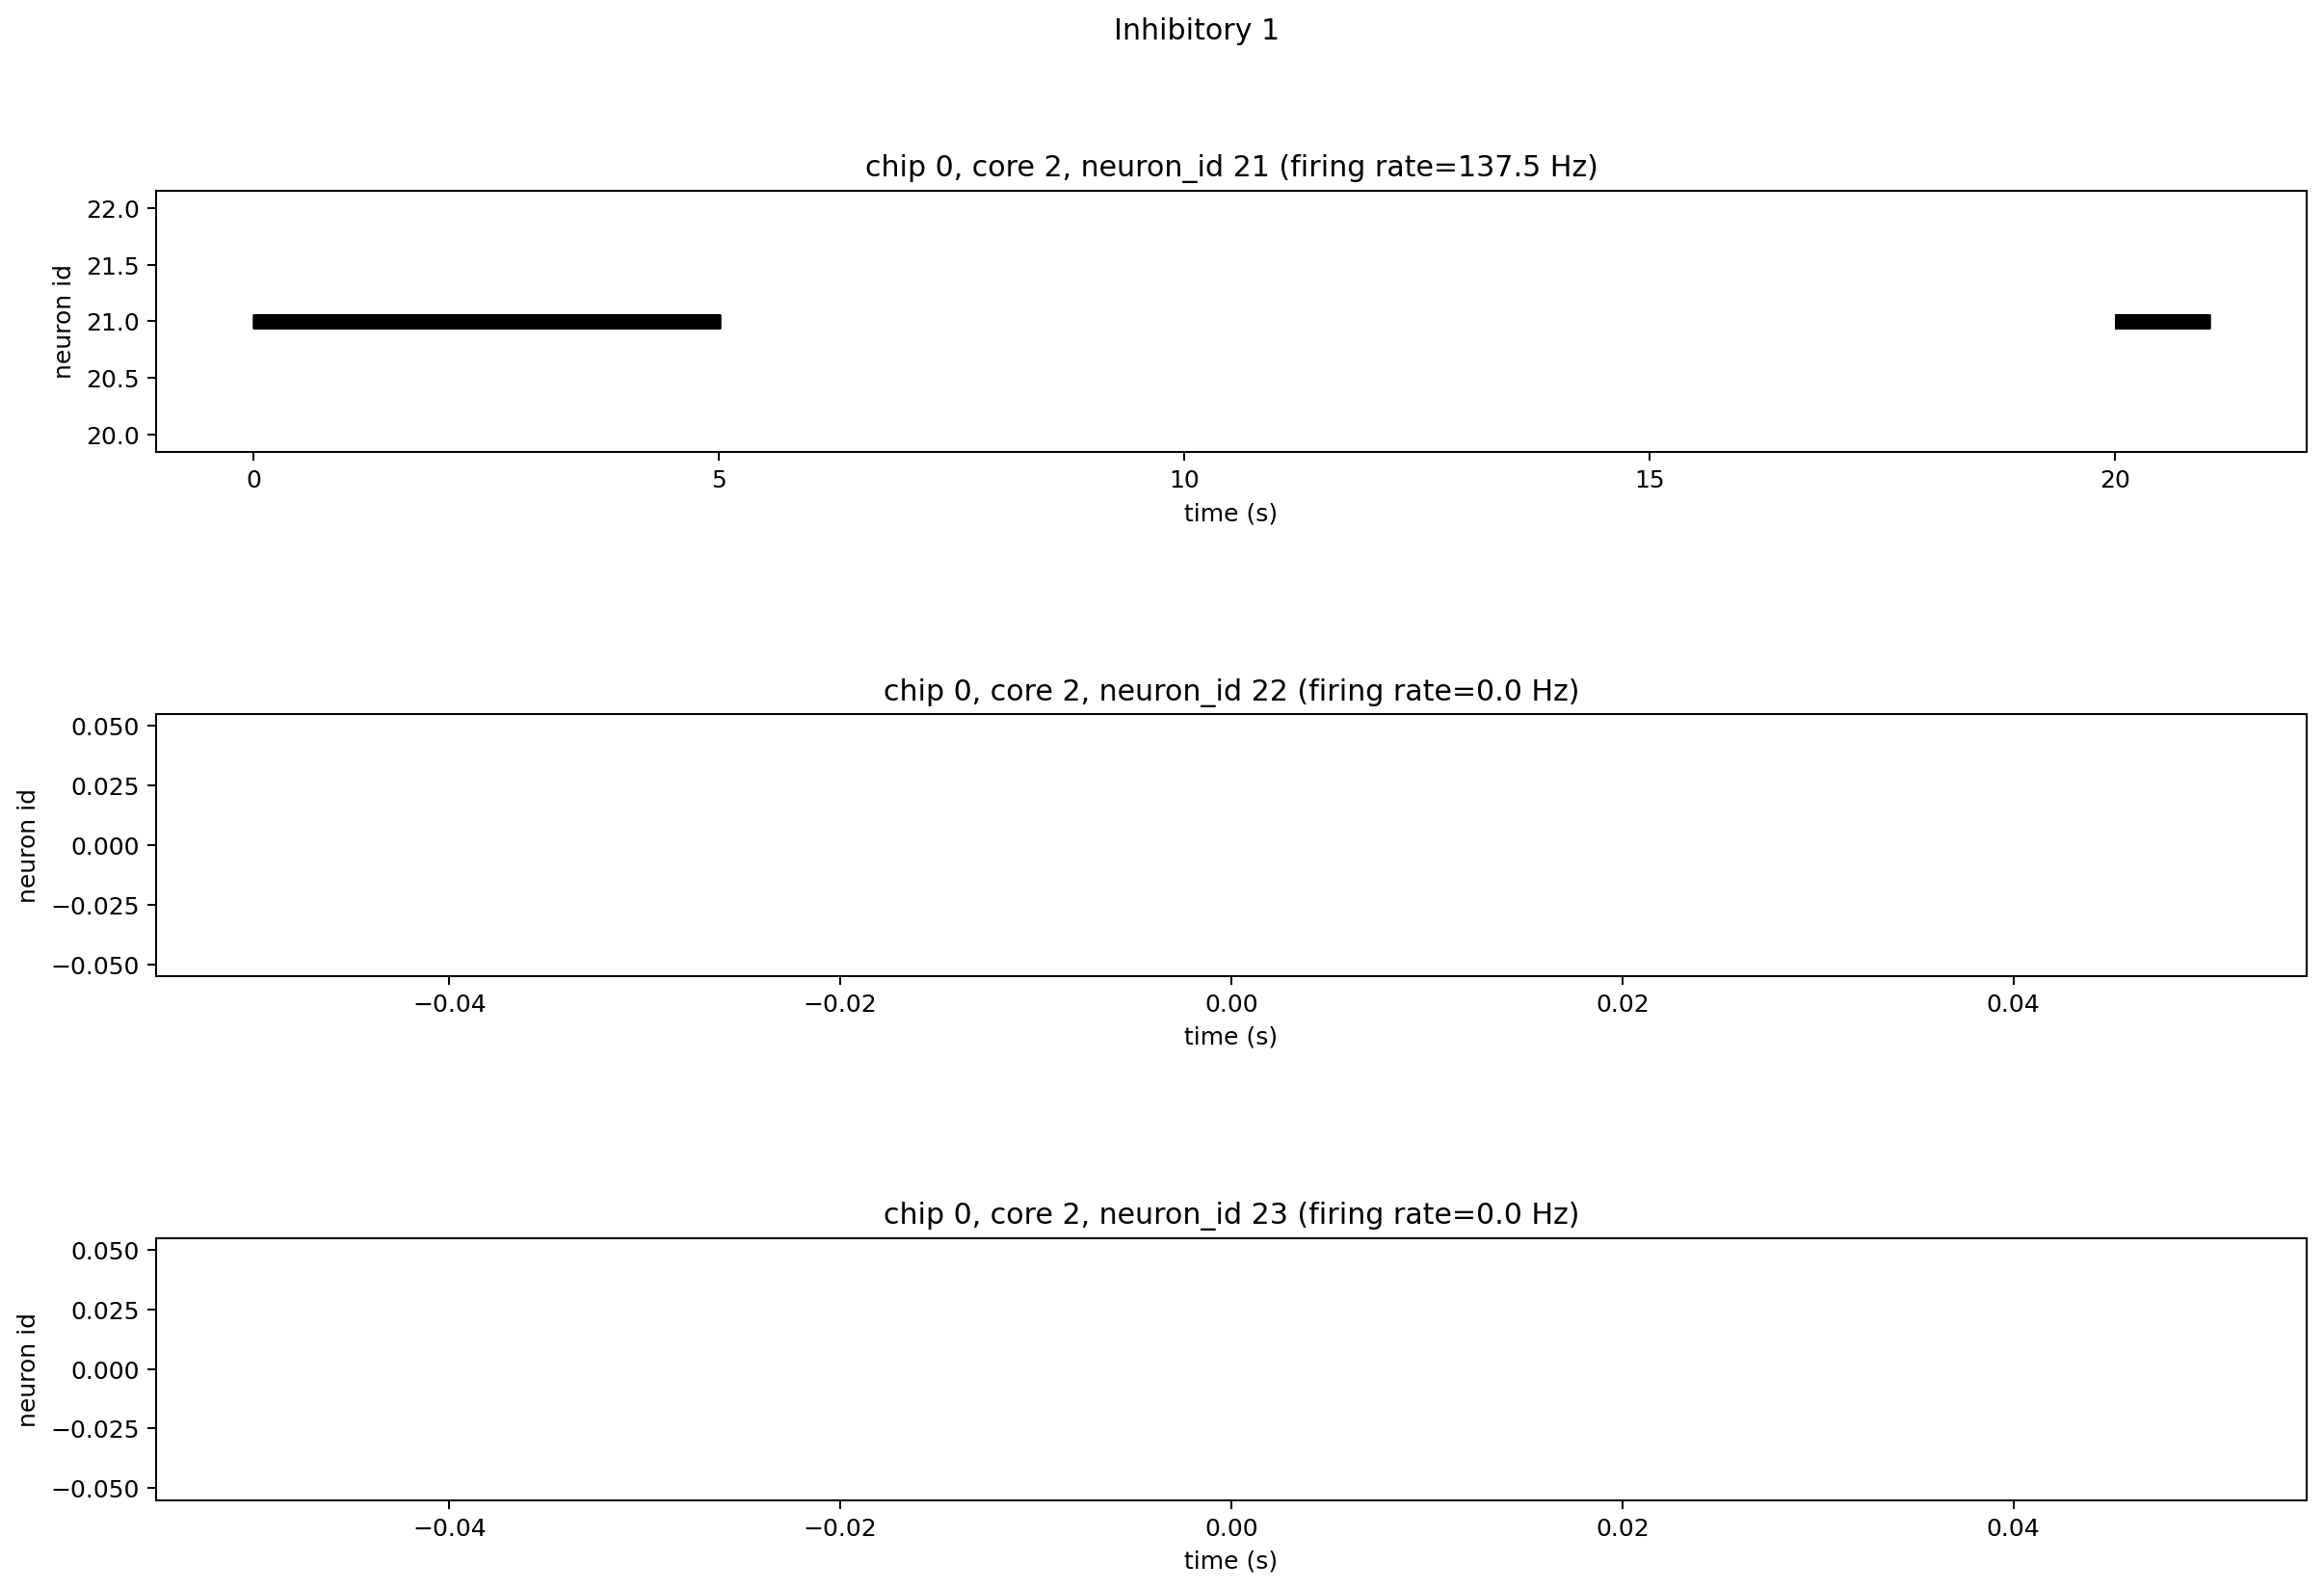

In [120]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'Inhibitory 1') 

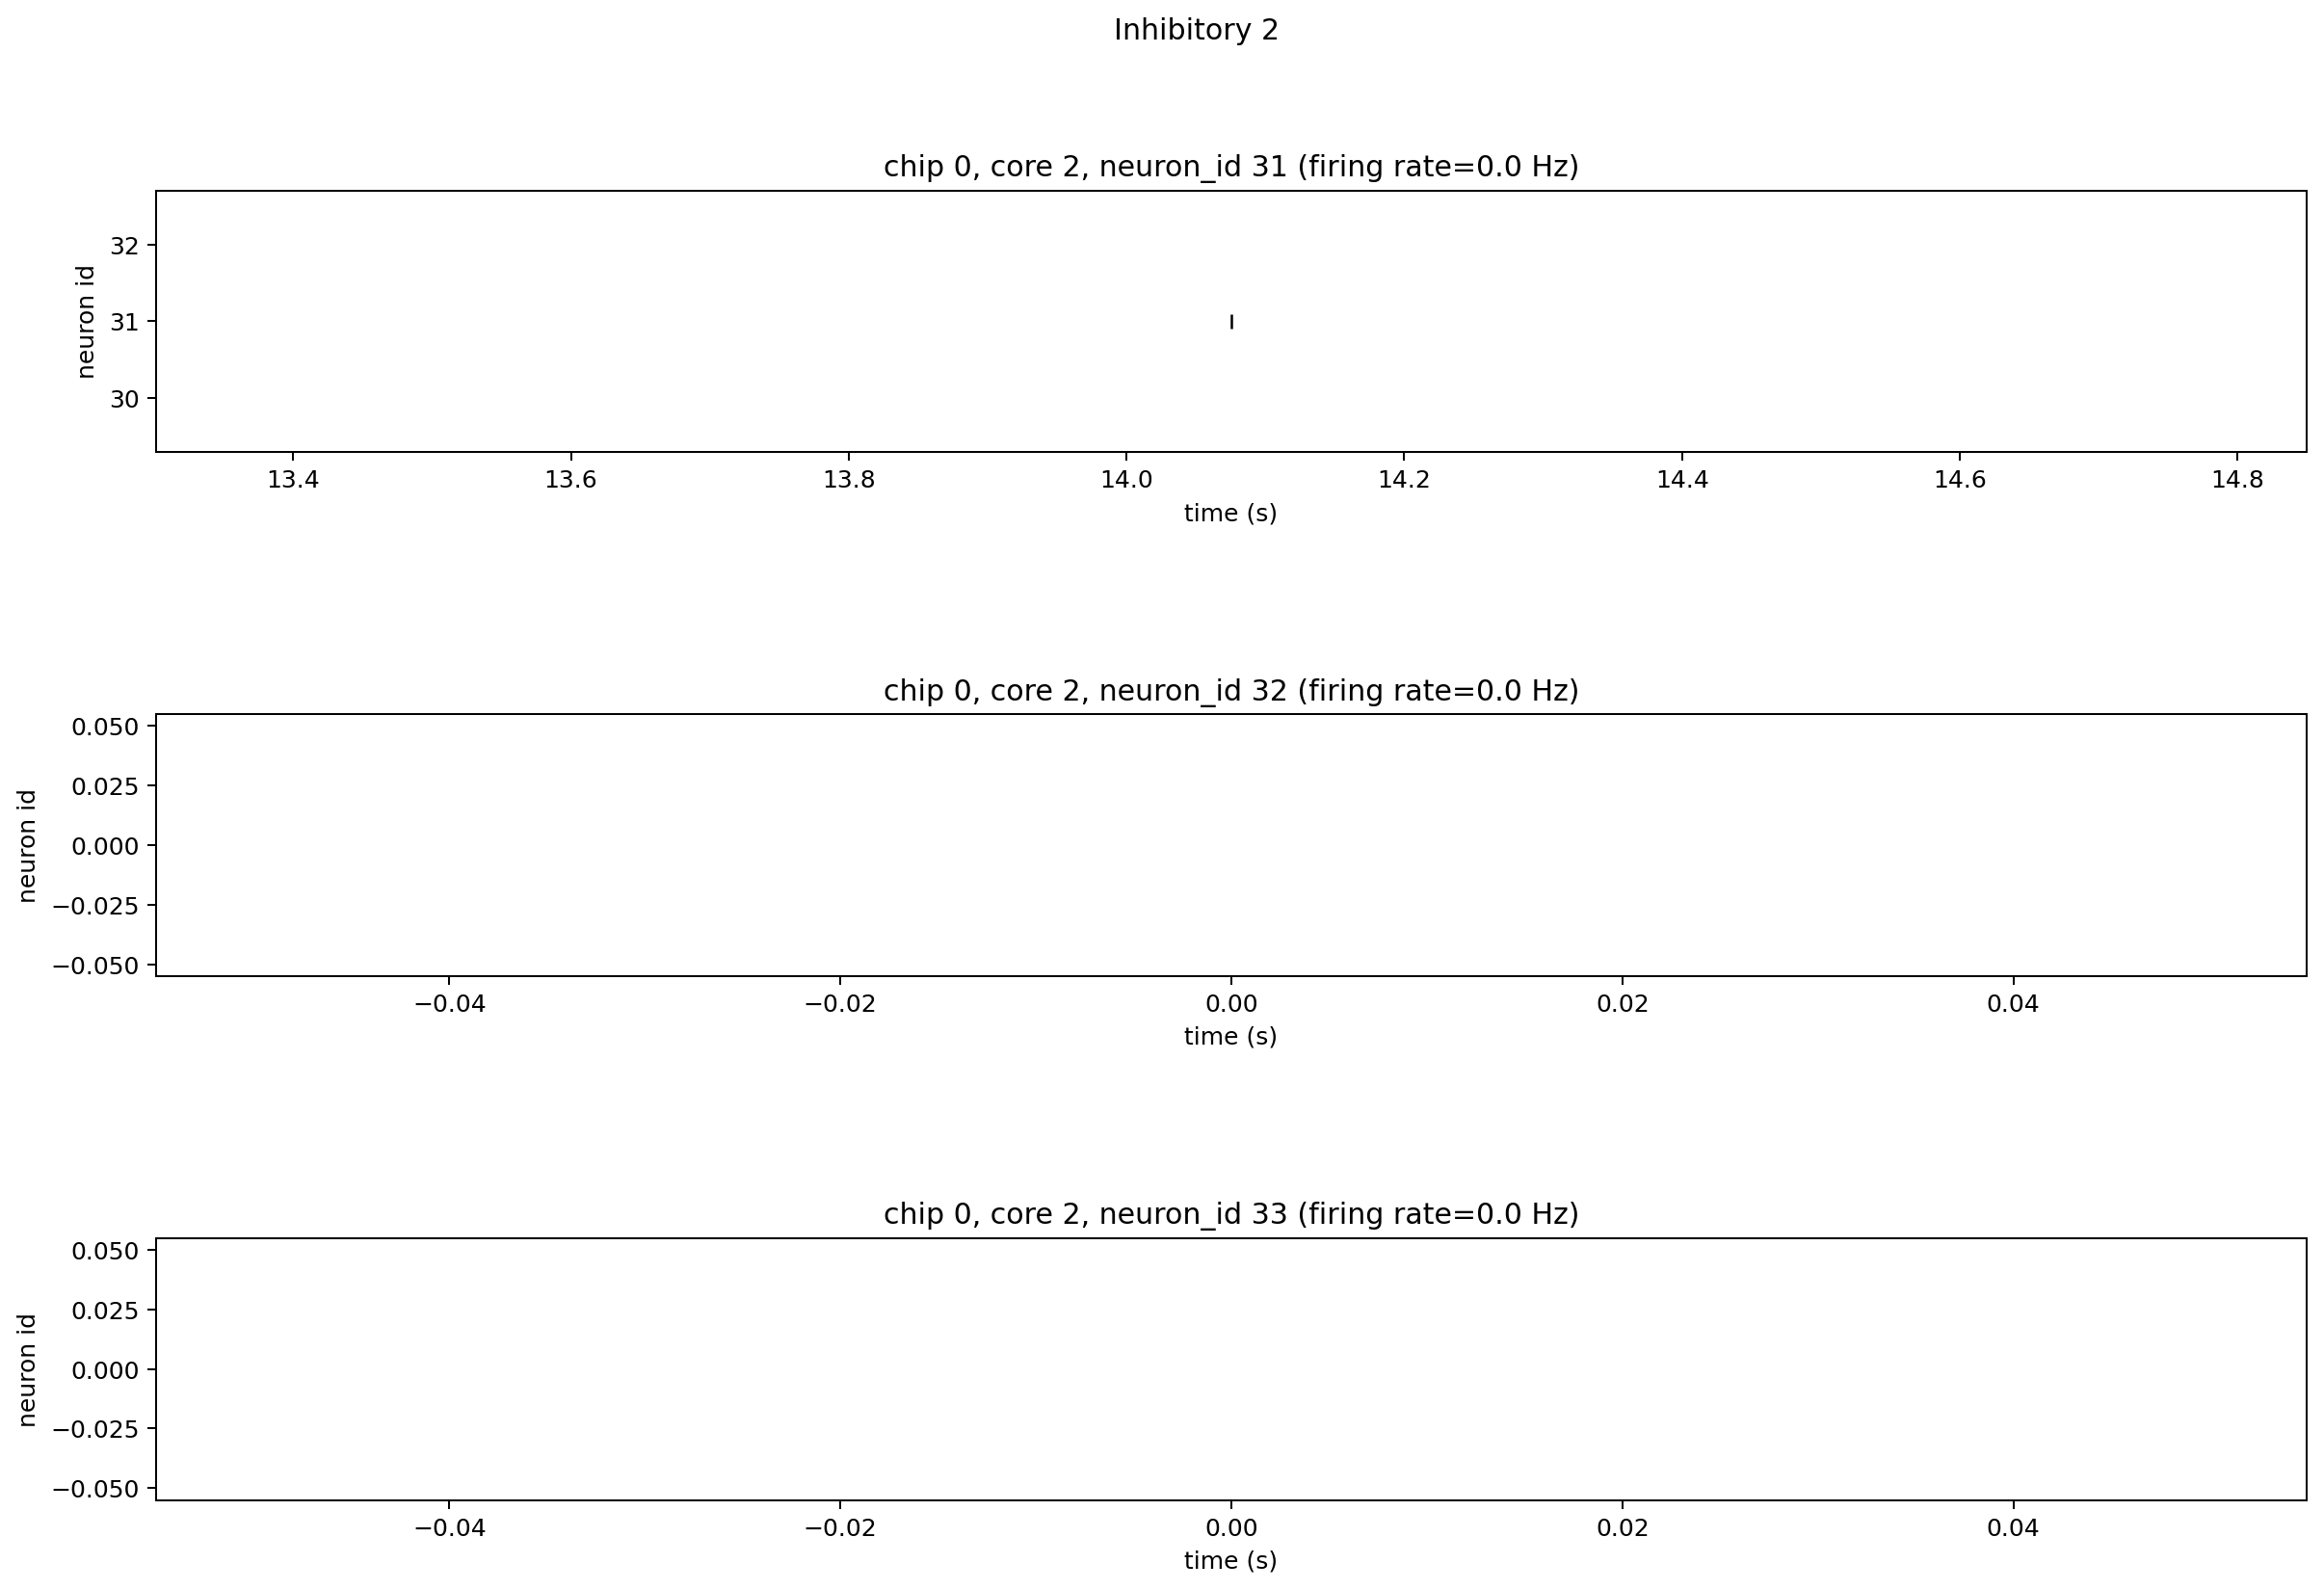

In [121]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'Inhibitory 2') 

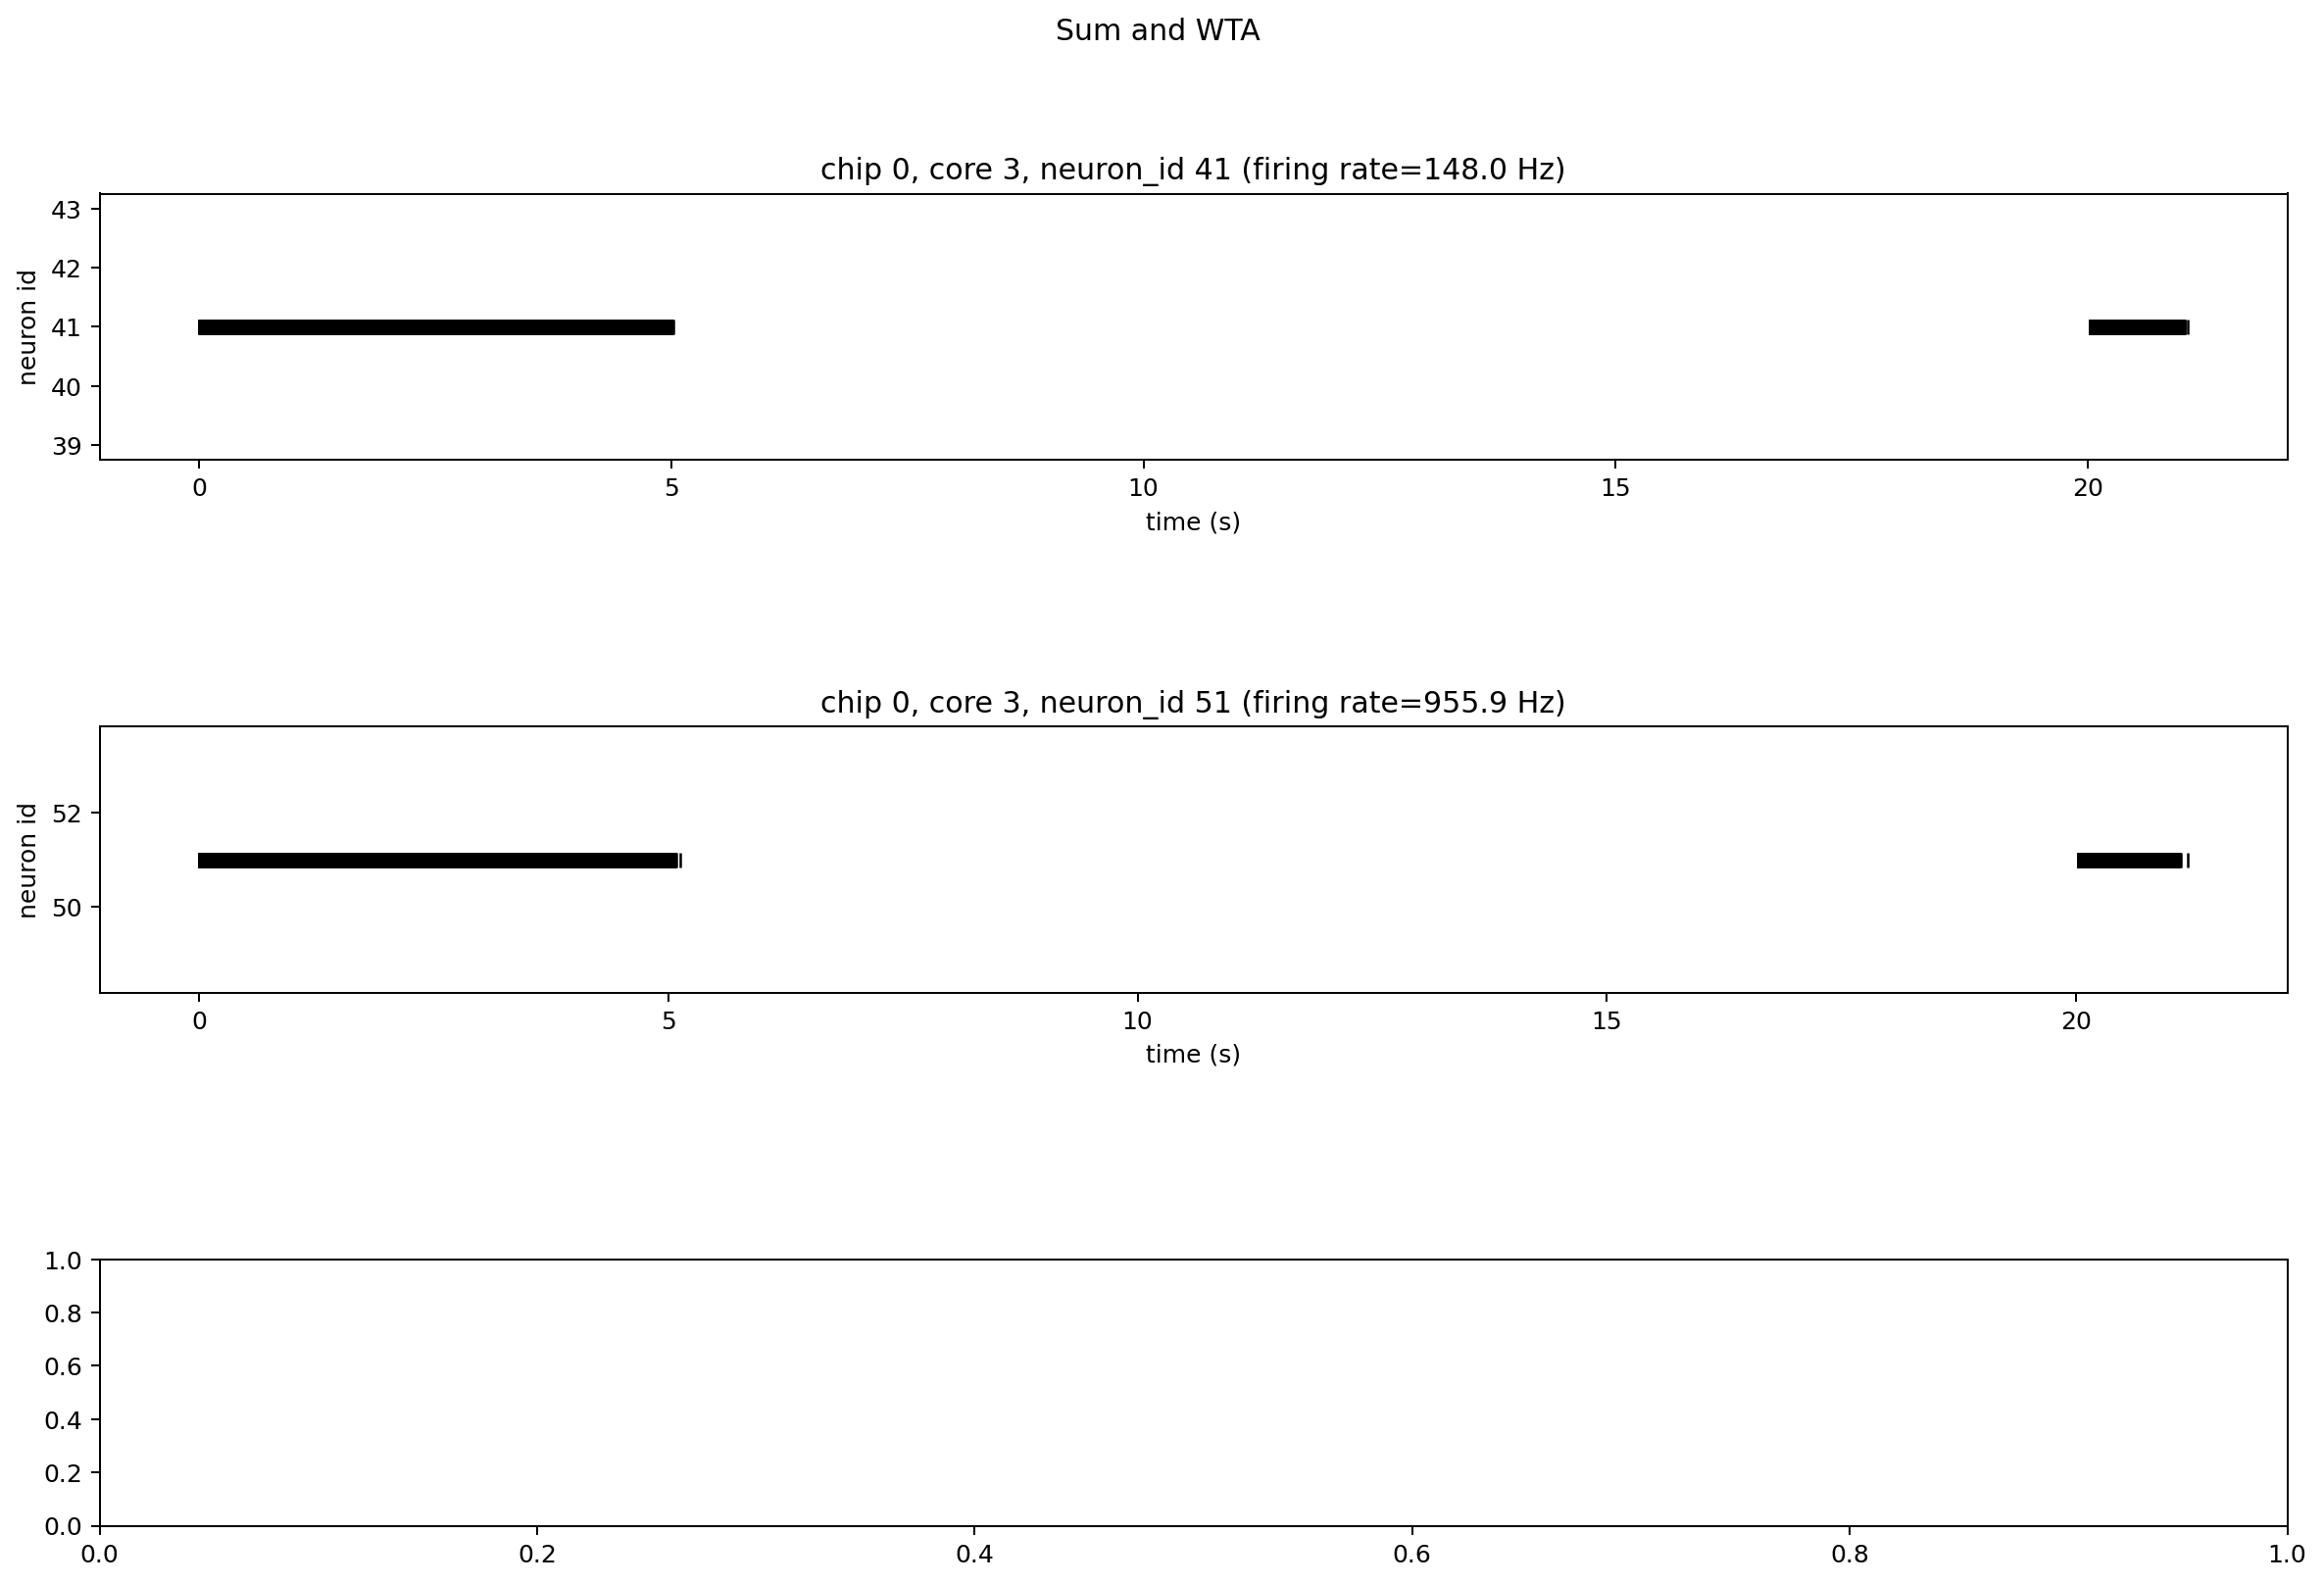

In [122]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'Sum and WTA') 